# Predicting survivols for the Titanic Dataset

In [26]:
import os
import math
import sys
from IPython.display import display

import pystan
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from utilities import my_utilities, psis, stan_utility
from utilities.my_utilities import *
plt.style.use("ggplot")

In [27]:
CONVERT_TO_PDF = True

# Introduction

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

This project aims to examine these differences in survival probability in depth. We hope to create an accurate model for predicting individual level survival probabilities. We chose survival status as our dependent variable and age, passenger class, sex, and embarkment city to be our independent variables. We aim at learning new insights on how these features affected the survival probablity of the participants in this tragedy that shook the world. 


# Data

The dataset we worked on was ready-made and aquired from Vanderbilt Biostatistics dataset collection (http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.html). The dataset relies on multiple sources major one being the Encyclopedia Titanica webpage. It contains information about all 1313 passengers including their whole names, sex, age, passenger class, and survival status among others. The dataset does not include information about the RMS Titanic crew. RMS Titanic had three different passenger classes.     

In [28]:
# data
data = pd.read_csv("../data/titanic.txt", index_col="name").drop(["row.names", 
                                                                  "home.dest", 
                                                                  "room", 
                                                                  "ticket", 
                                                                  "boat"], axis=1)

### Key statistics

In [29]:
pclass_summary = data.groupby('pclass').agg({
    'survived': ['sum', 'mean'],
    'age': [no_info, 'mean'],
    'sex': [females, males, tot], 
    'embarked': [Queenstown, Cherbourg, Southampton, no_info, tot]
})
pclass_summary["tot"] = data.pclass.value_counts()

final = pd.DataFrame()
final["Passengers"] = pclass_summary["tot"]
final["Men"] = pclass_summary["sex"]["males"]
final["Women"] = pclass_summary["sex"]["females"]
final["Age (avg)"] = pclass_summary["age"]["mean"]
final["Age unknown"] = pclass_summary["age"]["no_info"]
final["Queenstown"] = pclass_summary["embarked"]["Queenstown"]
final["Cherbourg"] = pclass_summary["embarked"]["Cherbourg"]
final["Southampton"] = pclass_summary["embarked"]["Southampton"]
final["Survived"] = pclass_summary["survived"]["sum"]
final["Percentage"] = pclass_summary["survived"]["mean"]

create_tex_table(final, 'key_stats.tex')

if not CONVERT_TO_PDF:
    display(final)

\begin{table}[H]
\centering
\caption{Key statistics by passenger class}
\resizebox{0.95\textwidth}{!}{
    \input{key_stats.tex}
}
\end{table}

# Logistic regression

Our first choice is to examine the data with logistic regression. We binarize categorical values, this case corresponding to passenger class, emberked city and sex, and remove all rows containing null values. It is notable that this removes major part of the original data. Moreover, has different effect on different passenger classes as over 70% of 3rd class passenger data is lost. 

## Prior choice



In [30]:
# binarize categorical variables, drop NaNs and normalize and scale "age" between 0 and 1
data_binarized = pd.get_dummies(data).dropna(axis=0, how="any")
data_binarized["child"] = (data_binarized["age"] < 15).astype(int)
data_binarized["elderly"] = (data_binarized["age"] > 60).astype(int)
data_binarized["age"] = preprocessing.minmax_scale(preprocessing.scale(np.array(data_binarized["age"])))

if not CONVERT_TO_PDF:
    data_binarized.head(n=3)

In [31]:
# create arrays for a stan model
features = ["age",
            "child",
            "elderly",
            "pclass_1st", 
            "pclass_2nd", 
            "pclass_3rd", 
            "embarked_Cherbourg", 
            "embarked_Queenstown", 
            "embarked_Southampton", 
            "sex_female"]

y = np.array(data_binarized["survived"])
X = np.array(data_binarized[features], dtype=np.dtype(float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("{0} samples in training set \n{1} samples in test set".format(y_train.size, y_test.size))

424 samples in training set 
209 samples in test set


## Pooled

In [32]:
model = stan_utility.compile_model('logistic_regression_pooled.stan')

Using cached StanModel


In [33]:
model_data = dict(n=X_train.shape[0],
                  d=X_train.shape[1], 
                  X=X_train, 
                  y=y_train, 
                  p_beta_df=4, 
                  p_beta_scale=1)
fit = model.sampling(data=model_data, seed=1, control=dict(max_treedepth=15))
samples = fit.extract(permuted=True)

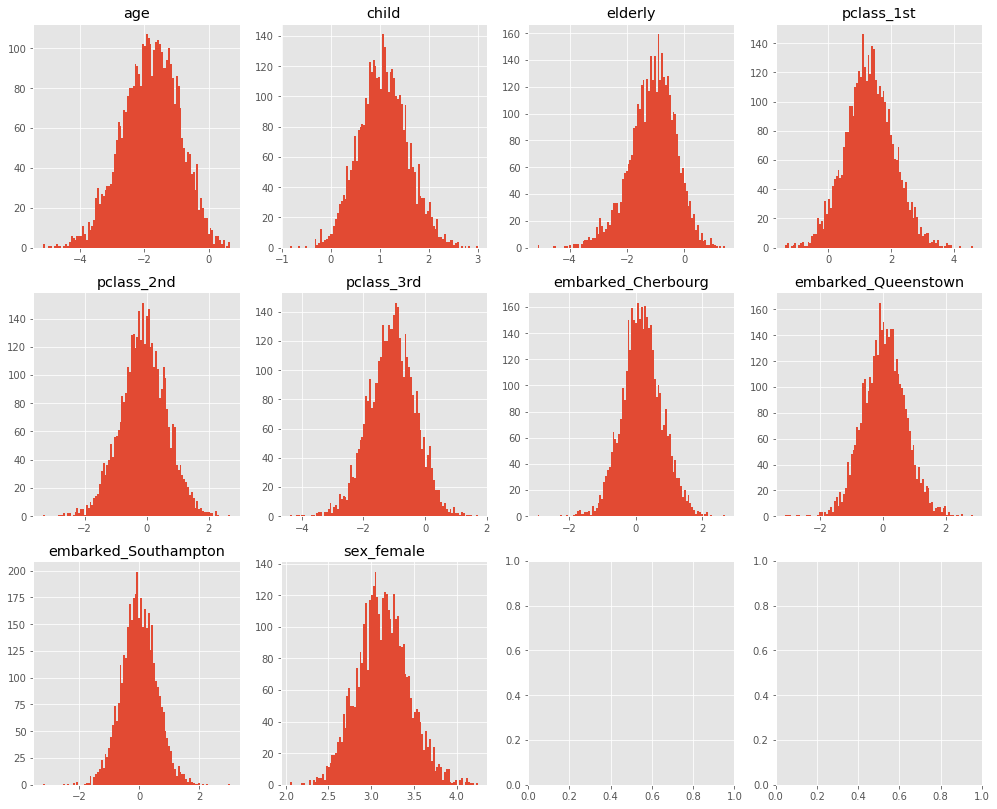

In [34]:
# plot betas
m = 4 
n = math.ceil(len(features)/m)
fig, axs = plt.subplots(n, m, figsize=(17, 14))
for i, (ax, feature) in enumerate(zip(axs.flat, features)):
    ax.hist(samples["beta"][:,i], bins=100)
    ax.set_title(feature)


## Model selection

p_eff: 8


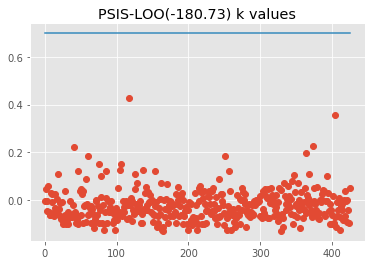

In [35]:
# LOO CV
loo, loos, ks = psis.psisloo(samples["log_lik"])
lppd = np.sum(np.log(np.sum(np.exp(samples["log_lik"]), axis=0)/4000))
print("p_eff: {}".format(int(lppd - loo)))

datapoints = np.arange(1, X_train.shape[0] + 1)
plt.plot(datapoints, ks, 'o')
plt.plot(datapoints, [0.7] * X_train.shape[0])
plt.title("PSIS-LOO({0}) k values".format(round(loo, 2)))
plt.show()

In [36]:
def logistic(x, beta, alpha):
    return (1+np.exp(-(alpha + np.dot(x, beta))))**(-1)

def check_accuracy(data, target, beta, alpha):
    ans_list = []
    for i in range(len(data)):
        res = logistic(data[i], beta, alpha)
        ans = 1 if res > 0.5 else 0
        ans_list.append(ans == target[i])

    return np.mean(ans_list)

mean_list = fit.summary()["summary"]
beta = mean_list[1:len(features)+1, 0]
alpha = mean_list[0, 0]


print('Accuracy train: ', check_accuracy(X_train, y_train, beta, alpha))
print('Accuracy test: ', check_accuracy(X_test, y_test, beta, alpha))

Accuracy train:  0.823113207547
Accuracy test:  0.799043062201


## Converge diagnostics

In [37]:
filt = ['alpha'] + ['beta[{}]'.format(i+1) for i in range(len(features))]
fit_logistic_regression = my_utilities.create_fit_table(fit, 'fit_logistic_regression.tex', filter=filt)

if not CONVERT_TO_PDF:
    display(fit_logistic_regression)

\begin{table}[H]
\centering
\caption{Logistic regression converge statistics}
\resizebox{0.75\textwidth}{!}{
    \input{fit_logistic_regression.tex}
}
\end{table}

## Results

## Sensitivity Analysis

# Discussion


# Appendix

## my_utilities.py